In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Dense, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

In [2]:
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        """Available Modes: convolutional, recursive (time), \n
        nfilt = number of mel filterbank filters \n
        nfeat = number of features, this is the number of mfcc coefficients. usually half of the filters. \n
        nfft = number of ffts \n
        rate = sample rate of files used."""
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [3]:
def build_rand_feat():
    X = [] #input variable
    y = [] #target variable
    #we will be taking slices of our inputs, and assigning the correct target variable to that slice ???
    _min, _max = float('inf'), -float('inf')
    #in neural nets, we want to normalise between 0 and 1 so it is good to know the min/max of features we will be processing
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist) #take a random class
        file = np.random.choice(df[df.label == rand_class].index) #take a random file from that class
        rate, wav = wavfile.read(f"./clean/{file.split('/')[-1]}") #read it in
        label = df.at[file, 'label'] #get label from df index of that file
        rand_index = 0 #random index in the wavfile ?? not sure if necessary for what i wanna do eventually but w/e
        try: #this should succeed if step size is lower than the length of the sample
            rand_index = np.random.randint(0, wav.shape[0]-config.step) #get a random index that can fit the step size.
        except: #if it fails, it is because the config step is bigger than the wav shape
            #zero padding to make sure all data is in the correct shape (atleast step_size)
            shape = np.shape(wav) #get shape of the wav
            padded_array = np.zeros((config.step,)) #make an array of zeroes that is the right shape
            padded_array[:shape[0]] = wav #fill the zeroes array with the values of the wav
            wav = padded_array #set the wav to the padded array
        sample = wav[rand_index:rand_index+config.step] #sample we are taking is a slice of config.step starting at rand_index
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T #take the transpose of the mfcc with config settings onto the sample obtained above

        _min = min(np.amin(X_sample), _min) #min becomes the minimum value present in our X_sample...
        _max = max(np.amax(X_sample), _max) #and max becomes the max
        X.append(X_sample if config.mode == 'conv' else X_sample.T)
        y.append(classes.index(label)) #categorical cross entropy??? 
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode =='conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode =='time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=len(class_dist.index))
    return X, y

def get_conv_model():
    model = Sequential() #this is just a mode where we can add layers to the model. functional is where you tell it which layers connect to what
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), 
                    padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1),padding='same'))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1),padding='same'))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

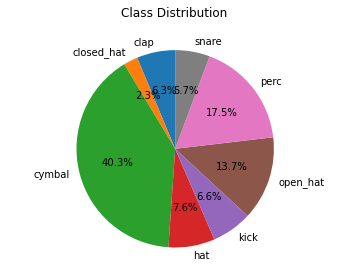

100%|██████████| 49062/49062 [00:38<00:00, 1284.77it/s]


In [4]:
df = pd.read_csv('./training/labelled_data.csv')
df.set_index('path', inplace=True)

for f in df.index:
    rate, signal = wavfile.read(f"./clean/{f.split('/')[-1]}")
    df.at[f,'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])["length"].mean()

#in the video, he is only going to care about 1/10th of a second. This will probably not be feasable for my needs but just noting for later
n_samples = 2*int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist) #of our class_dist(types of drum).index, draw a random choice with the same probability as the proportion of drum samples in the class dist


fig,ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
shadow = False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat() #will build a feature set from random sampling
    y_flat = np.argmax(y, axis=1) #take hot y and map back to original class encodings
    input_shape = (X.shape[1], X.shape[2],1)
    model = get_conv_model() #

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #take hot y and map back to original class encodings
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model() #

class_weight = compute_class_weight('balanced', classes=np.unique(y_flat), y=y_flat) #get some weights and looks at probability distribution, so when i make this weight matrix update im going to step a little bit further in the direction in my gradient descent to compensates class imbalance, and actually learn the features of low-proportion classes
class_weight = {i : class_weight[i] for i in range(len(class_weight))}

model.fit(X,y, epochs = 10, batch_size=32, shuffle=True, class_weight=class_weight)